In [2]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
sns.set_theme(color_codes=True)
from scipy import stats
import statsmodels.api as sm
import numpy as np
import json
from tqdm import tqdm_notebook 
import statsmodels.formula.api as smf

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read the Data

In [3]:
second_session_raw_data = pd.read_csv('Data/gono-go-game-second-round.csv', index_col=0).reset_index()
# second_session_raw_data = second_session_raw_data[second_session_raw_data.recorded_at > '2022-01-18']
# second_session_raw_data = second_session_raw_data[second_session_raw_data.mturkID != 'nan' ]

num_all_experimenters = len(second_session_raw_data.mturkID.unique())
num_excluded_experimenters = 0

second_session_raw_data['correct'] = second_session_raw_data.correct == 'true'

# second_session_raw_data.head()

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
len(second_session_raw_data.mturkID.value_counts())

135

# Apply exclusion criteria

1. Fail the quiz of instructions more than twice.
2. Change the tab or window of the experiment.

In [5]:
experimenter_status = second_session_raw_data[second_session_raw_data.trial_type == 'survey-html-form'][['run_id','mturkID', 'exp_final_status']]
IDs_for_inclusion_by_completed = experimenter_status[experimenter_status.exp_final_status == 'fully_completed'].mturkID

run_IDs_for_exclusion_by_changing_tabs = second_session_raw_data[second_session_raw_data.exp_final_status == 'not_completed_by_changing_tab'].run_id
run_IDs_for_exclusion_by_failing_quiz = second_session_raw_data[second_session_raw_data.exp_final_status == 'not_completed_by_failing_quiz'].run_id

second_session_clean_data = second_session_raw_data[second_session_raw_data.run_id.isin(run_IDs_for_exclusion_by_changing_tabs) == False]
second_session_clean_data = second_session_clean_data[second_session_clean_data.run_id.isin(run_IDs_for_exclusion_by_failing_quiz) == False]



num_excluded_experimenters = len(second_session_raw_data.mturkID.unique()) - len(second_session_clean_data.mturkID.unique())

print("Number of participants excluded by this criterias:", num_excluded_experimenters)

Number of participants excluded by this criterias: 4


In [6]:
# exclude the first try of a turker
second_session_clean_data = second_session_clean_data[second_session_clean_data.run_id != 204 ]
second_session_clean_data = second_session_clean_data[second_session_clean_data.run_id != 14]
second_session_clean_data.mturkID.replace({"A2TLN8489YGY81_agaign": "A2TLN8489YGY81"}, inplace=True)


In [7]:
second_session_clean_data.mturkID.isna().sum()

0

3. Respond randomly, always go or never go.

    * Note: We exclude who repond randomly, always go or nogo in each 3 block

In [8]:
susp = second_session_clean_data[second_session_clean_data.suspicious == 'true'][['mturkID', 'suspicious_type','num_gos', 'block']]

In [9]:
IDs_for_exclusion_by_random_response = list(susp.mturkID.value_counts()[ (susp.mturkID.value_counts() == 3) | (susp.mturkID.value_counts() == 2) ].index)

num_excluded_experimenters += len(IDs_for_exclusion_by_random_response)

second_session_clean_data = second_session_clean_data[second_session_clean_data.mturkID.isin(IDs_for_exclusion_by_random_response) == False]

print("Number of participants excluded by this criterias:", len(IDs_for_exclusion_by_random_response))


Number of participants excluded by this criterias: 5


In [10]:
second_session_clean_data.mturkID.isna().sum()

0

In [11]:
second_session_clean_data.mturkID.unique().shape

(125,)

4. Their rate of the correct response to detection of circle side task is less than 55%.

In [12]:
circle_side_correctness = second_session_clean_data[second_session_clean_data.choice == 'go'][['mturkID','side', 'response']]
circle_side_correctness['is_correct_circle_side'] =  (circle_side_correctness.side == circle_side_correctness.response)
accuracy_data = circle_side_correctness.groupby('mturkID').mean().reset_index()
accuracy_data.columns = ['mturkID', 'rate']
accuracy_data['is_below_55'] = accuracy_data.rate < 0.55

# accuracy_data.head()


In [13]:
non_accurate_IDs = list(accuracy_data[accuracy_data.is_below_55 == True].mturkID)

num_excluded_experimenters += len(non_accurate_IDs)

second_session_clean_data = second_session_clean_data[second_session_clean_data.mturkID.isin(list(non_accurate_IDs)) == False]
print("Number of participants excluded by this criterias:", len(non_accurate_IDs))



Number of participants excluded by this criterias: 11


In [14]:
second_session_clean_data.mturkID.isna().sum()

0

In [15]:
second_session_clean_data[second_session_clean_data.mturkID.isna()].run_id.unique()

array([], dtype=int64)

In [16]:
second_session_clean_data.mturkID.unique().shape

(114,)

# Plot Perforance per conditions

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_6641/2126368423.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)


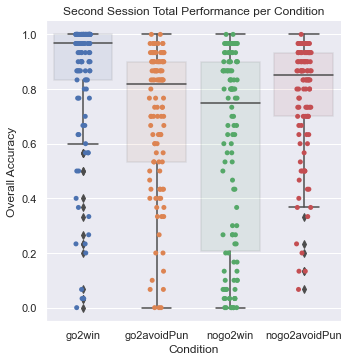

In [17]:
mapping = {'1': 'go2win', '2': 'nogo2win', '3': 'go2avoidPun', '4' : 'nogo2avoidPun'} 

circle_task_logs = second_session_clean_data[second_session_clean_data.exp_stage == 'main_target_detection']

circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)
performance_per_condition = circle_task_logs.groupby(['mturkID','cond']).mean().reset_index()
performance_per_condition.cond = performance_per_condition.cond.map(mapping)


ax = sns.catplot(x="cond", y="correct", data=performance_per_condition, order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);
ax = sns.boxplot(x="cond", y="correct", data= performance_per_condition, boxprops=dict(alpha=.1), order= ['go2win','go2avoidPun' ,'nogo2win', 'nogo2avoidPun']);

ax.set(xlabel="Condition", ylabel = "Overall Accuracy", title = 'Second Session Total Performance per Condition')
plt.show()


In [18]:
len(second_session_clean_data.mturkID.unique())

114

# Extract Demographic datas

In [62]:
len(raw_demographic_data.mturkID.unique())

114

In [63]:
# raw_demographic_data = second_session_clean_data[second_session_clean_data.trial_type == 'survey-html-form'][['mturkID', 'response']]
raw_demographic_data = second_session_clean_data[(second_session_clean_data.response != "") & (second_session_raw_data.trial_type == 'survey-html-form')][['mturkID', 'response']].drop_duplicates(subset=['mturkID'], keep='last')

raw_demographic_data['gender'] = raw_demographic_data.response.apply(lambda x: x.split('"')[3])
raw_demographic_data['age'] = raw_demographic_data.response.apply(lambda x: x.split('"')[7])
raw_demographic_data['education_level'] = raw_demographic_data.response.apply(lambda x: x.split('"')[11])
raw_demographic_data['comments'] = raw_demographic_data.response.apply(lambda x: x.split('"')[15])
raw_demographic_data = raw_demographic_data.drop(['response'], axis=1)
# raw_demographic_data.shape

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_71884/3402330953.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  raw_demographic_data = second_session_clean_data[(second_session_clean_data.response != "") & (second_session_raw_data.trial_type == 'survey-html-form')][['mturkID', 'response']].drop_duplicates(subset=['mturkID'], keep='last')


In [64]:
circle_task_logs['cond'] = circle_task_logs.cond_action + '2' + circle_task_logs.cond_outcome 
GOs = (circle_task_logs[circle_task_logs.choice == 'go'].groupby(['mturkID']).count()['run_id'].rename('second_num_GOs'))
noGos = (circle_task_logs[circle_task_logs.choice == 'nogo'].groupby(['mturkID']).count()['run_id'].rename('second_num_noGos'))
go2win_Gos = (circle_task_logs[(circle_task_logs.choice == 'go') & (circle_task_logs.cond == 'go2win')].groupby(['mturkID']).count()['run_id'].rename('second_num_go2win_Gos'))
nogo2avoidpun_noGos = (circle_task_logs[(circle_task_logs.choice == 'nogo') & (circle_task_logs.cond == 'nogo2avoidPun')].groupby(['mturkID']).count()['run_id'].rename('second_num_nogo2avoidPun_noGos'))
new_pav_metric_df = pd.concat([GOs, noGos, go2win_Gos, nogo2avoidpun_noGos], axis=1)


/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_71884/4121152230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['cond'] = circle_task_logs.cond_action + '2' + circle_task_logs.cond_outcome


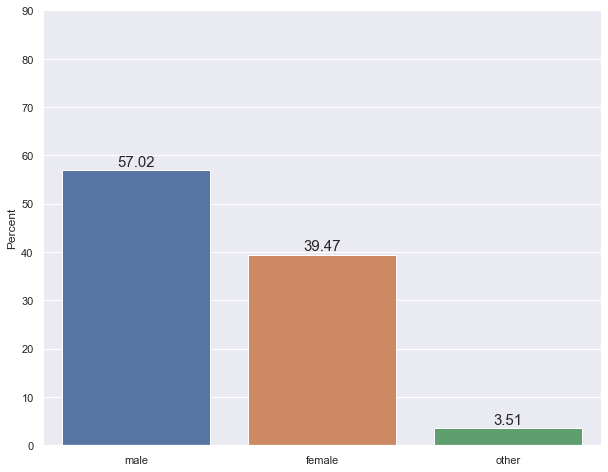

In [65]:
plt.figure(figsize=(10,8))
plt.ylabel("Percent")
gender_percent = (raw_demographic_data.gender.value_counts(normalize=True))*100
gender_percent[0]
ax = sns.barplot(y = gender_percent,x = gender_percent.index)
ax.set_yticks(np.arange(0, 100, 10));
ax.set_ylabel("Percent");

for bar in ax.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()


In [67]:
sum_age = []
for i in (raw_demographic_data.age):
    try:
        sum_age.append(int(i))
    except:
        print("ERRRR")
np.mean(sum_age)

39.24561403508772

# Create final data to analyze

In [63]:
final_performace_data = performance_per_condition.pivot(index='mturkID', columns='cond', values='correct').reset_index()


final_performace_data = pd.merge(final_performace_data, accuracy_data, on='mturkID')
final_performace_data = pd.merge(final_performace_data, raw_demographic_data, on='mturkID')
final_performace_data.columns = ['mturkID', 'go2avoidPun_second_session', 'go2win_second_session', 'nogo2avoidPun_second_session', 'nogo2win_second_session', 'circle_side_performance_second_session',\
       'is_below_55_second_session', 'gender_second_session', 'age_second_session', 'education_level_second_session', 'comments_second_session']
overall_performance =  final_performace_data['nogo2win_second_session'] + \
                        final_performace_data['go2win_second_session'] + \
                        final_performace_data['nogo2avoidPun_second_session'] + \
                        final_performace_data['go2avoidPun_second_session']
final_performace_data['overall_performance'] = overall_performance/4

final_performace_data = final_performace_data.merge(new_pav_metric_df, on='mturkID', how='left')

final_performace_data.head()

,mturkID,go2avoidPun_second_session,go2win_second_session,nogo2avoidPun_second_session,nogo2win_second_session,circle_side_performance_second_session,is_below_55_second_session,gender_second_session,age_second_session,education_level_second_session,comments_second_session,overall_performance,second_num_GOs,second_num_noGos,second_num_go2win_Gos,second_num_nogo2avoidPun_noGos
0,A10BH9PYCYUKDJ,0.500000,0.8,0.600000,0.266667,1.000000,False,female,41,Associate,},0.541667,73,47,24.0,18
1,A10JXOU89D5RXR,0.900000,1.0,0.900000,0.700000,0.986667,False,female,60,Bachelor,},0.875000,69,51,30.0,27
2,A11S8IAAVDXCUS,0.200000,1.0,0.633333,0.133333,1.000000,False,female,31,Associate,},0.491667,73,47,30.0,19
3,A12FTSX85NQ8N9,0.866667,1.0,0.966667,0.866667,1.000000,False,male,29,Bachelor,},0.925000,61,59,30.0,29
4,A12HZGOZQD5YK7,0.966667,1.0,0.966667,0.800000,1.000000,False,female,41,Associate,},0.933333,66,54,30.0,29


In [64]:
final_performace_data.shape

(114, 16)

In [65]:
final_performace_data.drop_duplicates().to_csv('Data/second_round_final_performance.csv')

# Pav axis

(0.0, 1.0)

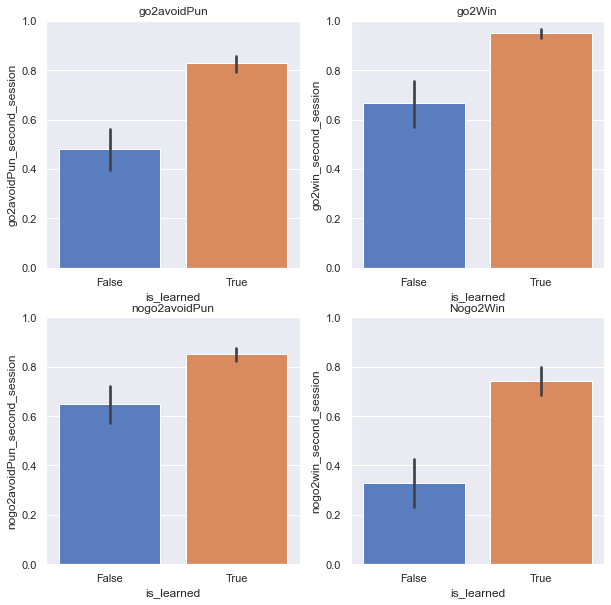

In [66]:
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(10,10))
plt.ylim(0, 1)

final_performace_data['is_learned'] = final_performace_data.overall_performance > 0.65

sns.barplot(x="is_learned", y="nogo2win_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,1)]).set_title('Nogo2Win')

axs[1,1].set_ylim(0,1)

sns.barplot(x="is_learned", y="go2win_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,1)]).set_title('go2Win')
axs[0,1].set_ylim(0,1)



sns.barplot(x="is_learned", y="go2avoidPun_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,0)]).set_title('go2avoidPun')
axs[0,0].set_ylim(0,1)



sns.barplot(x="is_learned", y="nogo2avoidPun_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,0)]).set_title('nogo2avoidPun')
axs[1,0].set_ylim(0,1)




# modelling

In [67]:
result_of_trials = circle_task_logs[['mturkID', 'internal_node_id', 'response', 'side', 'choice', 'cond_action', 'cond_outcome','correct_action', 'outcome', 'feedback_points', 'block']].copy()

result_of_trials['stimulus'] = result_of_trials['cond_action'] + '2' + result_of_trials['cond_outcome']
result_of_trials['is_go'] = result_of_trials.choice == 'go'
result_of_trials['is_go'].replace({True: 1, False: 0}, inplace=True)


In [69]:
result_of_trials[['mturkID','choice', 'feedback_points', 'stimulus']].to_csv('data_for_modeling_matlab_second_session.csv')

In [25]:
result_of_trials.to_csv('Data/second_round_result_of_trials.csv')

In [26]:
go2win_go_prob = pd.Series(np.zeros(30))
go2win_prob_df = pd.DataFrame()

nogo2win_go_prob = pd.Series(np.zeros(30))
nogo2win_prob_df = pd.DataFrame()

go2avoidPun_go_prob = pd.Series(np.zeros(30))
go2avoidPun_prob_df = pd.DataFrame()

nogo2avoidPun_go_prob = pd.Series(np.zeros(30))
nogo2avoidPun_prob_df = pd.DataFrame()




for mID in result_of_trials.mturkID.dropna().unique():
    go_of_every_subject = result_of_trials[result_of_trials['mturkID']== mID][['is_go','stimulus']].reset_index(drop=True)
    for s in ['go2win','nogo2win','go2avoidPun', 'nogo2avoidPun']:
        go_of_every_subject_in_s = go_of_every_subject[go_of_every_subject.stimulus == s].reset_index(drop=True)
        if( s == 'go2win'):
            go2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2win'):
            nogo2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'go2avoidPun'):
            go2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2avoidPun'):
            nogo2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()


/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_2364/3190507868.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_2364/3190507868.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_2364/3190507868.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

(0.0, 1.0)

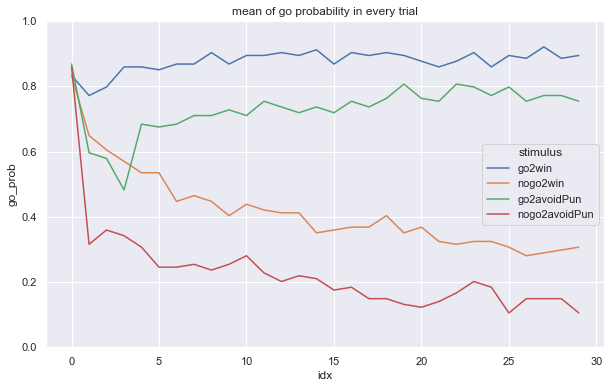

In [27]:
go_prob_df = pd.DataFrame({'go2win': go2win_go_prob, 
                            'nogo2win': nogo2win_go_prob,
                            'go2avoidPun': go2avoidPun_go_prob,\
                            'nogo2avoidPun': nogo2avoidPun_go_prob})

# go_prob_df['idx'] = go_prob_df.index

go_prob_df = go_prob_df.melt().rename(columns={'variable': 'stimulus', 'value': 'go_prob'})
go_prob_df.loc[go_prob_df.stimulus == 'go2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'go2avoidPun', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2avoidPun', 'idx'] = range(0,30)

plt.figure(figsize=(10,6))
ax = sns.lineplot(x="idx", y="go_prob",
             hue="stimulus", 
             data=go_prob_df)
plt.title("mean of go probability in every trial")
plt.ylim(0,1)

 

In [28]:
from sys import path
from dotenv import load_dotenv
import os
load_dotenv();

path.append(os.environ.get("MODELING_PATH"))

from fitting import ML

In [28]:
np.random.seed(30)
modeling_result_df = {}
modeling_result_df['mturkID'] = []

modeling_result_df['alpha'] = []
modeling_result_df['beta'] = []
modeling_result_df['noise'] = []
modeling_result_df['go_bias'] = []
modeling_result_df['pav_bias'] = []


def fit_subject_with_id(subject_id):
    df = result_of_trials[result_of_trials.mturkID == subject_id]
    df = df[['choice','stimulus','feedback_points']].rename(columns={'choice':'action', 'feedback_points':'reward'}).reset_index(drop=True)
    df['reward'] = pd.to_numeric(df.reward)

    max_likelihood = ML(df, optimization_method='Nelder-Mead', model_type='RW+noise+bias+Pav', initial_guess=np.random.normal(0,1,1)[0]*np.array([0.1,0.1,0.1,0.1,0.1]), without_bound=True)
    res = max_likelihood.fit_model()
    return res



In [29]:
# for subject in tqdm_notebook(result_of_trials.mturkID.unique()):
#     res = fit_subject_with_id(subject)

#     modeling_result_df['mturkID'].append(subject)
#     modeling_result_df['alpha'].append(1 / (1+ np.exp(-res.x[0])))
#     modeling_result_df['beta'].append(np.exp(res.x[1]))
#     modeling_result_df['noise'].append(1 / (1+ np.exp(-res.x[2])))
#     modeling_result_df['go_bias'].append(res.x[3])
#     modeling_result_df['pav_bias'].append(np.exp(res.x[4]))




In [30]:
# mr_df = pd.DataFrame(modeling_result_df)
# mr_df['pav_bias_log'] = np.log(mr_df.pav_bias)

In [75]:
# mr_df.to_csv('./Data/modeling_result_second_session.csv')
mr_df = pd.read_csv("result_of_modeling_matlab_second_session.csv")


In [76]:
mr_df

,mturkID,alpha,beta,noise,bias,pav
0,A10BH9PYCYUKDJ,0.417260,1.278276,0.973897,0.633984,0.856317
1,A10JXOU89D5RXR,0.351415,9.182360,0.977700,-0.051141,0.296479
2,A11S8IAAVDXCUS,0.046502,2.737302,0.979895,1.012645,3.032539
3,A12FTSX85NQ8N9,0.477884,20.573321,0.974275,1.018938,0.456361
4,A12HZGOZQD5YK7,0.831383,5.926205,0.983101,1.356952,0.133423
5,A12X8RUSITV7RU,0.370050,10.569988,0.983998,-0.272723,0.324097
6,A136K4YZY2OFTV,0.339092,15.137805,0.986370,1.240029,0.150644
7,A14W0AXTJ3R19V,0.205979,6.024924,0.979438,1.202816,0.184088
8,A173MXK429XAZQ,0.212184,21.954545,0.935652,0.786419,0.108317
9,A1AF25FCVKC87X,0.283273,5.015019,0.981007,0.697521,0.351201


# dist of log(pav bias)

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pav', ylabel='Density'>

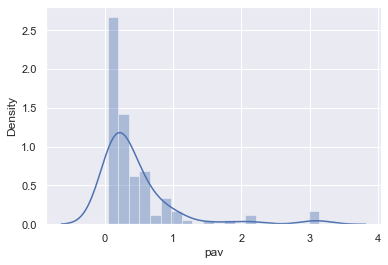

In [77]:
sns.distplot(mr_df.pav )

# dist of learning rate

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alpha', ylabel='Density'>

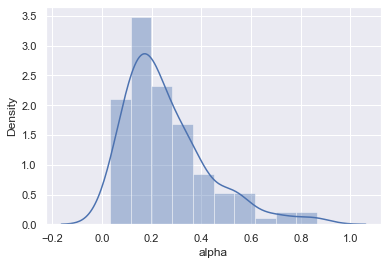

In [78]:
sns.distplot((mr_df.alpha), bins=10) 

# dist of go bias

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bias', ylabel='Density'>

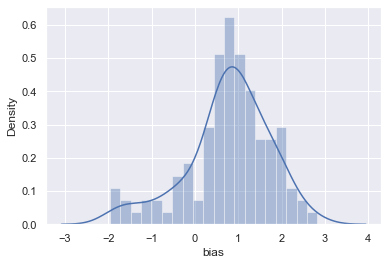

In [79]:
sns.distplot((mr_df.bias), bins=20) 

# dist of log(sensitivity to reward)

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='beta', ylabel='Density'>

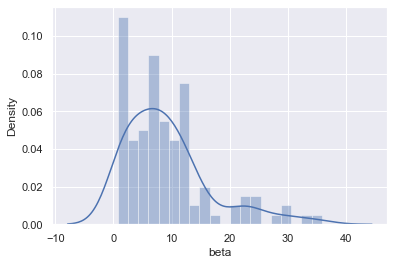

In [80]:
sns.distplot(((mr_df.beta)), bins=20) 

In [82]:
mr_perf = pd.merge(mr_df, final_performace_data, on='mturkID')
mr_perf['gw_ngw'] = mr_perf.go2win_second_session - mr_perf.nogo2win_second_session

mr_perf['non_par_pav'] = mr_perf.go2win_second_session + mr_perf.nogo2avoidPun_second_session - mr_perf.nogo2win_second_session - mr_perf.go2avoidPun_second_session

mr_perf['non_par_go_bias']  = mr_perf.go2win_second_session + mr_perf.go2avoidPun_second_session - mr_perf.nogo2win_second_session - mr_perf.nogo2avoidPun_second_session


<AxesSubplot:xlabel='bias', ylabel='nogo2win_second_session'>

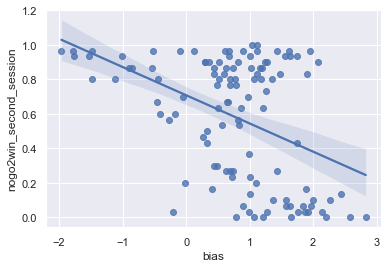

In [83]:
sns.regplot(x=('bias'), y='nogo2win_second_session', data = mr_perf)



# log(pav bias) & (g2win - nogo2win) performance 

<AxesSubplot:xlabel='pav', ylabel='non_par_pav'>

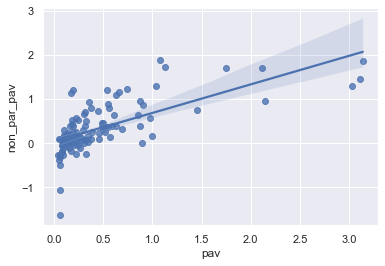

In [84]:
sns.regplot(y=('non_par_pav'), x='pav', data = mr_perf)

<AxesSubplot:xlabel='pav', ylabel='gw_ngw'>

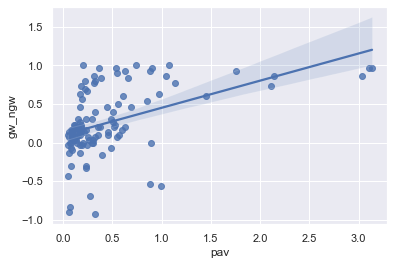

In [85]:
sns.regplot(x=('pav'), y='gw_ngw', data = mr_perf)

In [86]:
smf.ols(formula = 'non_par_pav ~ pav', data = mr_perf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            non_par_pav   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     97.69
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           6.11e-17
Time:                        11:13:14   Log-Likelihood:                -58.148
No. Observations:                 114   AIC:                             120.3
Df Residuals:                     112   BIC:                             125.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0409      0.048      0.844      0.400      -0.055       0.137
pav            0.6483      0.066      9.884      0.000       0.518       0.778
==============================================================================
Omnibus:                       13.517   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.984
Skew:                          -0.143   Prob(JB):                     4.64e-10
Kurtosis:                       5.995   Cond. No.                         2.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# learning rate & (g2win - nogo2win) performance 

<AxesSubplot:xlabel='alpha', ylabel='gw_ngw'>

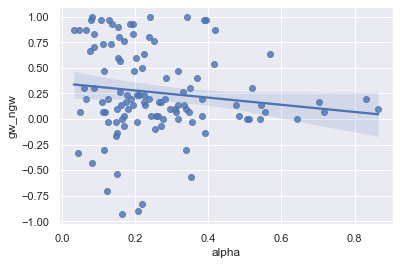

In [69]:
sns.regplot(x=(mr_perf['alpha']), y=mr_perf['gw_ngw'])

In [70]:
smf.ols(formula = 'gw_ngw ~ alpha', data = mr_perf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gw_ngw   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.066
Date:                Mon, 28 Feb 2022   Prob (F-statistic):              0.153
Time:                        08:47:09   Log-Likelihood:                -64.509
No. Observations:                 114   AIC:                             133.0
Df Residuals:                     112   BIC:                             138.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3493      0.075      4.683      0.000       0.202       0.497
alpha         -0.3506      0.244     -1.437      0.153      -0.834       0.133
==============================================================================
Omnibus:                        2.631   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.077
Skew:                          -0.301   Prob(JB):                        0.354
Kurtosis:                       3.276   Cond. No.                         6.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""